In [89]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# Reading Data using Pandas and SQLite3

In [2]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        ull_tables.append(pd.read_sql_query('SELECT COUNTERS_ULL_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_ULL_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_ULL_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].replace({'WWAHost.exe': 'Netflix.exe'}) 
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].str.lower()
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Mouse cursor icon state.', 'ID_INPUT'] = 2
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Foreground window .exe process.', 'ID_INPUT'] = 3
    ull_df = join_tables(ull_tables)
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse X position in pixel(s)', 'ID_INPUT'] = 0
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse Y position in pixel(s)', 'ID_INPUT'] = 1
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is immersive.', 'ID_INPUT'] = 4
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is hung.', 'ID_INPUT'] = 5
    return (string_df.drop('INPUT_DESCRIPTION', axis=1), ull_df.drop('INPUT_DESCRIPTION', axis=1))

# Problem 2
Predict the total time an application is used in the foreground.

### Problem 2a

C:\Users\jared\AppData\Local\Temp/ipykernel_11532/1043798672.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
C:\Users\jared\AppData\Local\Temp/ipykernel_11532/1043798672.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);


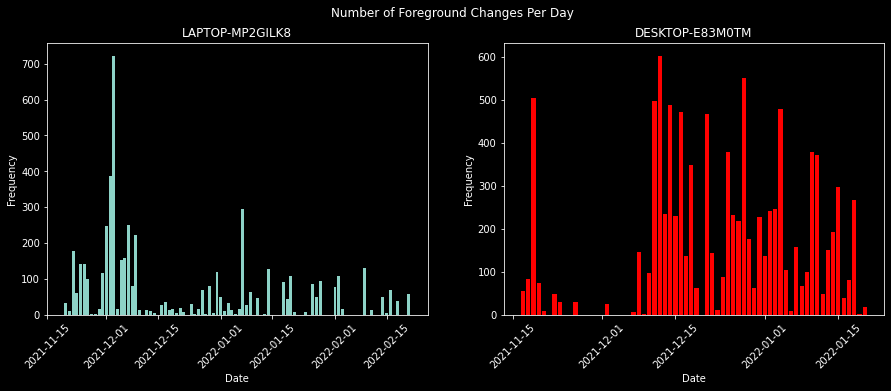

In [75]:
# getting datasets
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')
string_df_1, ull_df_1 = get_all_databases('group3_collected_data_pc_1')

# getting foregrounds of laptop
string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']

# getting foregrounds of desktop
string_df_1['MEASUREMENT_TIME'] = string_df_1['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of Foreground Changes Per Day')
plt.style.use('dark_background');

ax1.bar(x=foreground_0.index, height=foreground_0.values)
# ax1.tick_params(rotation=45);
ax1.set_title('LAPTOP-MP2GILK8');
ax1.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
ax1.set(xlabel='Date', ylabel='Frequency');

ax2.bar(x=foreground_1.index, height=foreground_1.values, color='red')
# ax2.tick_params(rotation=45);
ax2.set_title('DESKTOP-E83M0TM');
ax2.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
ax2.set(xlabel='Date', ylabel='Frequency');

In [99]:
def clean_lstm_2(df, computer=0, time_max=60):
    
    temp = df.copy()
    
    # getting foreground applications only
    temp = temp[temp['ID_INPUT'] == 3].drop(['ID_INPUT', 'PRIVATE_DATA'], axis=1).reset_index(drop=True)
    # converting 'MEASUREMENT_TIME' column to datetime
    temp.loc[:, 'MEASUREMENT_TIME'] = pd.to_datetime(temp['MEASUREMENT_TIME'])
    # getting values only between '2021-11-20' and '2021-12-10' for laptop data
    if computer == 0:
        temp = temp[(temp['MEASUREMENT_TIME'] >= pd.to_datetime('2021-11-20')) & (temp['MEASUREMENT_TIME'] <= pd.to_datetime('2021-12-10'))].reset_index(drop=True)
    # getting values after '2022-01-07' for desktop data
    else:
        temp = temp[temp['MEASUREMENT_TIME'] >= pd.to_datetime('2022-01-07')].reset_index(drop=True)
    # using converted datetime column to get usage per application ('TIME_DELTA')
    time_delta = (temp['MEASUREMENT_TIME'].shift(periods=-1) - temp['MEASUREMENT_TIME']).drop(len(temp)-1).apply(lambda x: float(x.total_seconds() / 60))
    time_delta = time_delta.append(pd.Series(-1), ignore_index=True)
    # getting usage per future application ('TIME_DELTA_1')
    time_delta_1 = time_delta.shift(-1)
    # adding 'TIME_DELTA' and 'TIME_DELTA_1' to DataFrame, dropping last instances with no values, and converting outliers (large numbers) to 60 minute values
    temp = temp.assign(**{'TIME_DELTA': time_delta, 'TIME_DELTA_1': time_delta_1})
    temp = temp.drop([len(temp)-2, len(temp)-1]).drop(['MEASUREMENT_TIME', 'VALUE'], axis=1)
    # maxing the time spent per foreground at 60 minutes, as users are very likely to be inactive after 60 mins
    temp = temp.applymap(lambda x: 60 if x > 60 else x)
    
    return temp

def split_lstm_2(df, test_size=0.2):
    
    # defining splits
    train_size = 1 - test_size
    n_test = int(np.ceil(len(df) * test_size))
    n_train = int(np.floor(len(df) * train_size))
    train = df.loc[:n_train, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)
    test = df.loc[n_train:, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)
    
    # fitting scaler with training set
    scaler = StandardScaler()
    scaler.fit(train[:, 0].reshape(-1,1))
    train = scaler.transform(train[:, 0].reshape(-1,1))
    test = scaler.transform(test[:, 0].reshape(-1,1))
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    # getting 5 previous events to use for single next prediction
    n_past = 5
    n_future = 1
    for i in range(n_past, len(train) - n_future + 1):
        X_train.append(train[i-n_past: i])
        y_train.append(train[i+n_future-1: i+n_future])
    X_train, y_train = np.array(X_train), np.array(y_train)

    for i in range(n_past, len(test) - n_future + 1):
        X_test.append(test[i-n_past: i])
        y_test.append(test[i+n_future-1: i+n_future])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    return X_train, X_test, y_train, y_test

def lstm_2(X_train, y_train):
    
    # defining model with 2 LSTM layers
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(32, activation='relu'))
    model.add(keras.layers.Dense(1))
    # defining optimizer and loss function
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [110]:
# cleaning data
df = clean_lstm_2(string_df_0)

# splitting data
X_train, X_test, y_train, y_test = split_lstm_2(df)

# initializing LSTM
model = lstm_2(X_train, y_train)

# fitting training data to model
model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1, shuffle=False)

# getting predictions
y_pred = model.predict(X_test)

# # saving predictions to .txt file
# output = pd.Series(y_pred.flatten())
# output.to_csv('./output_lstm_2', header=True, index=None, sep=',', mode='w')

Epoch 1/10
137/137 [==============================] - 2s 6ms/step - loss: 0.2717 - val_loss: 0.2752
Epoch 2/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2546 - val_loss: 0.2748
Epoch 3/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2544 - val_loss: 0.2748
Epoch 4/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2542 - val_loss: 0.2747
Epoch 5/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2540 - val_loss: 0.2749
Epoch 6/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2540 - val_loss: 0.2745
Epoch 7/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2539 - val_loss: 0.2748
Epoch 8/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2538 - val_loss: 0.2746
Epoch 9/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2539 - val_loss: 0.2746
Epoch 10/10
137/137 [==============================] - 1s 4ms/step - loss: 0.2536 - val_loss: 0.2747

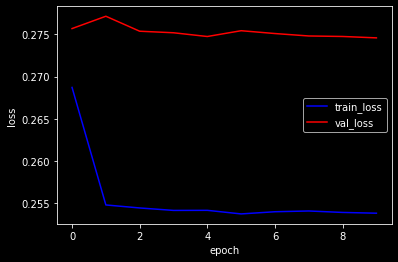

In [103]:
# plotting training and validation losses
plt.plot(np.arange(10), history.history['loss'], label='train_loss', c='blue')
plt.plot(np.arange(10), history.history['val_loss'], label='val_loss', c='red')
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend();